=== SHAPES ===
Users: (1000, 6)
Modules: (30, 5)
Ratings: (20000, 3)

=== NULL VALUES ===
                  users_nulls  modules_nulls  ratings_nulls
user_id                   0.0            NaN            0.0
user_cluster              0.0            NaN            NaN
digital_literacy          0.0            NaN            NaN
age_group                 0.0            NaN            NaN
risk_profile              0.0            NaN            NaN
preferred_topic           0.0            NaN            NaN
module_id                 NaN            0.0            0.0
scam_type                 NaN            0.0            NaN
difficulty                NaN            0.0            NaN
target_literacy           NaN            0.0            NaN
duration_min              NaN            0.0            NaN
rating                    NaN            NaN            0.0

=== UNIQUE IDENTIFIERS ===
Unique user_id: True
Unique module_id: True

=== DUPLICATES CHECK ===
Duplicate (user_id,module_id) pa

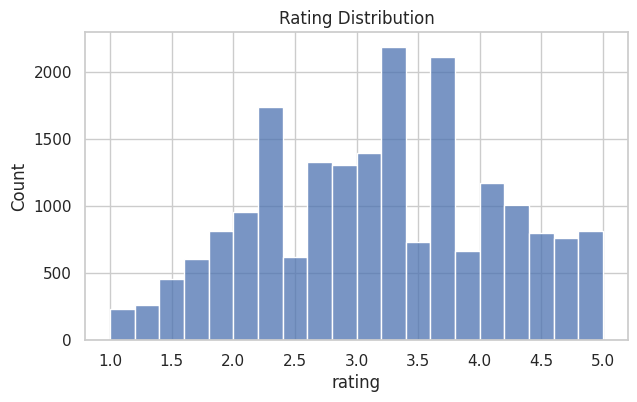

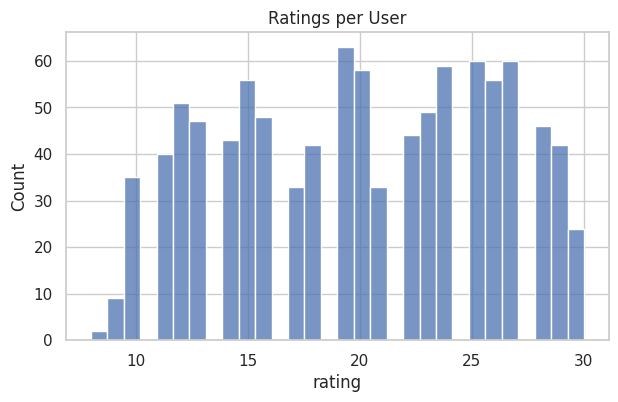

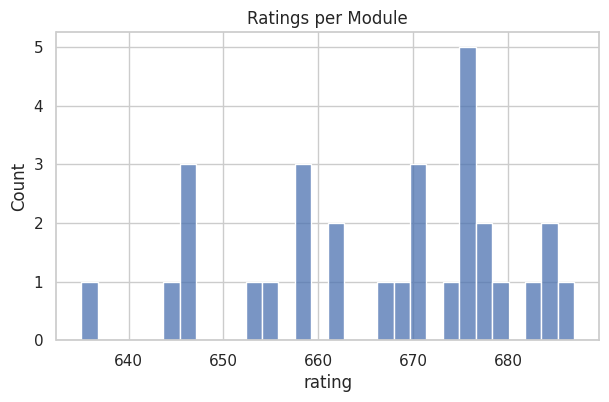


=== SPARSITY ===
Possible interactions: 30000
Actual interactions: 20000
Sparsity: 0.33333333333333337

=== COLD START ===
Users with 0 ratings: 0
Users with <3 ratings: 0
Modules with 0 ratings: 0
Modules with <10 ratings: 0


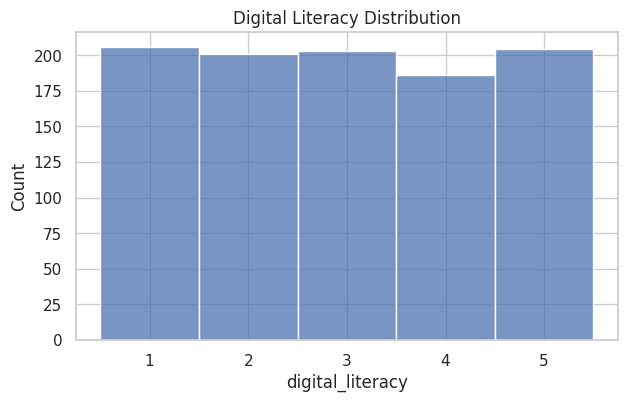

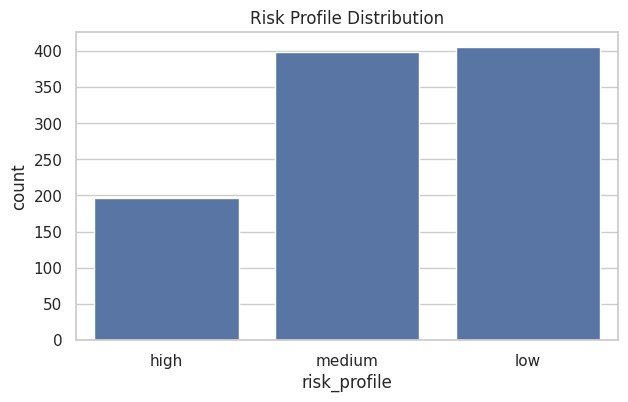

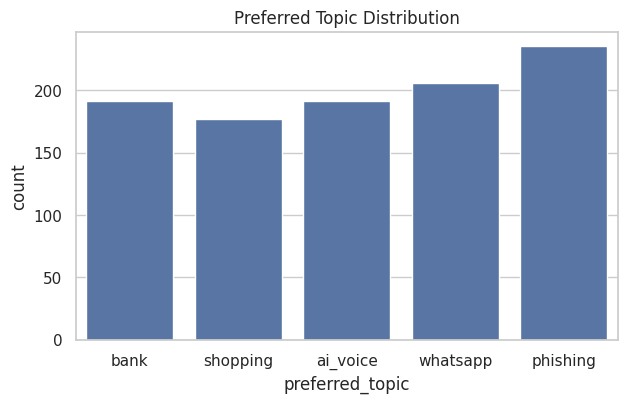

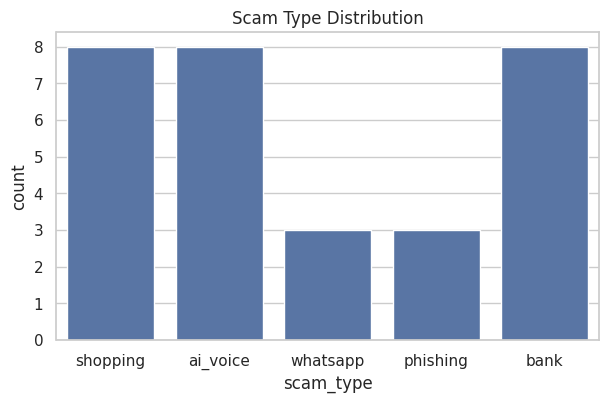

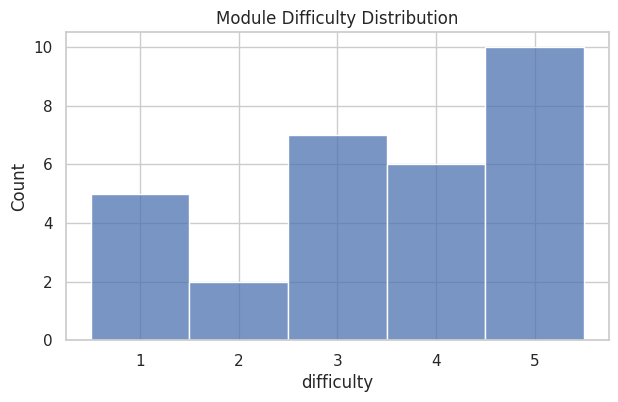

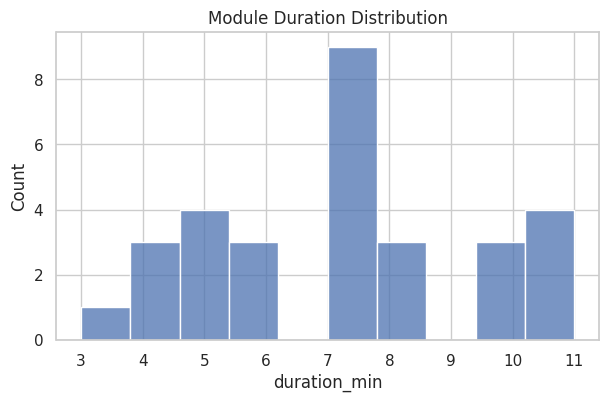

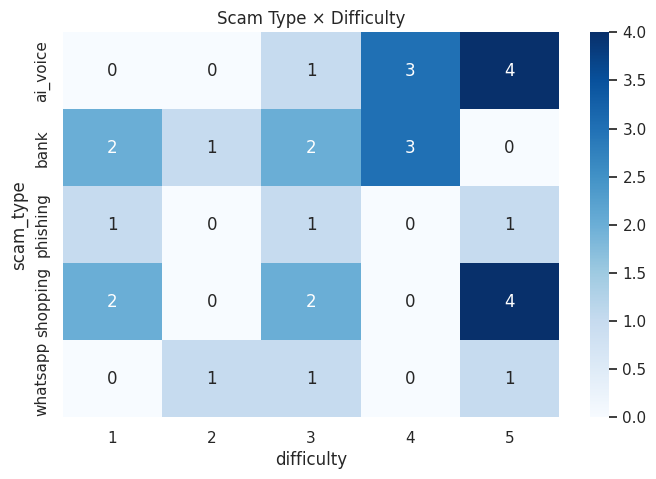

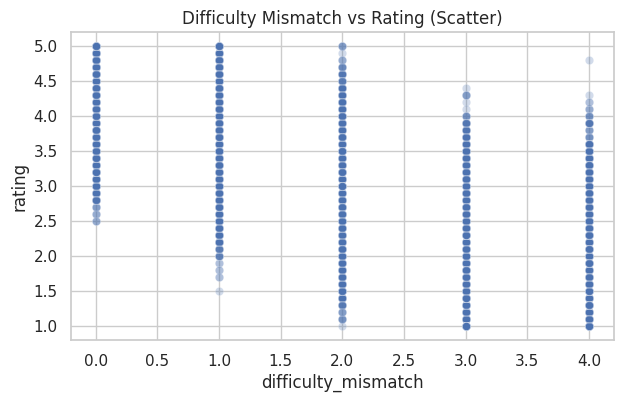

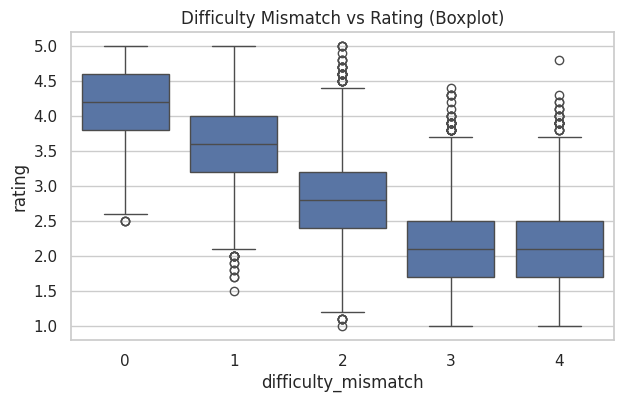

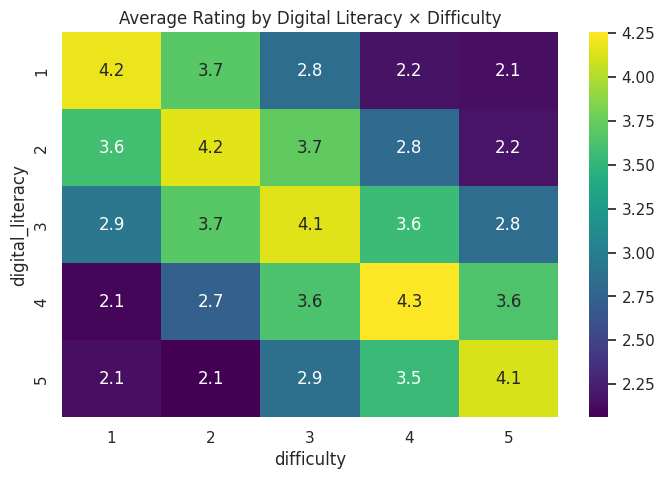



=== EDA SUMMARY CONCLUSIONS ===
1. Dataset is structurally correct: no duplicates, all IDs unique.
2. Sparsity (~0.33) is realistic and ideal for MF training.
3. No cold-start problems: all modules & all users have ratings.
4. Rating distribution is logical and centered around 2.5–4.5.
5. Mismatch effect visible: higher mismatch → lower rating.
6. Heatmaps confirm that synthetic rating rules behave as intended.
7. Dataset is ready for ML.NET training.


In [1]:
# ============================================================
# EDA FOR SYNTHETIC RECOMMENDER DATASET (FINAL VERSION)
# users.csv, modules.csv, ratings.csv
# ============================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set(style="whitegrid")
os.makedirs("eda_plots", exist_ok=True)

# ------------------------------------------------------------
# 1. LOAD DATA
# ------------------------------------------------------------

users = pd.read_csv("users.csv")
modules = pd.read_csv("modules.csv")
ratings = pd.read_csv("ratings.csv")

print("=== SHAPES ===")
print("Users:", users.shape)
print("Modules:", modules.shape)
print("Ratings:", ratings.shape)

print("\n=== NULL VALUES ===")
print(pd.concat({
    "users_nulls": users.isnull().sum(),
    "modules_nulls": modules.isnull().sum(),
    "ratings_nulls": ratings.isnull().sum()
}, axis=1))

print("\n=== UNIQUE IDENTIFIERS ===")
print("Unique user_id:", users["user_id"].is_unique)
print("Unique module_id:", modules["module_id"].is_unique)

print("\n=== DUPLICATES CHECK ===")
dup = ratings.duplicated(subset=["user_id", "module_id"]).sum()
print("Duplicate (user_id,module_id) pairs:", dup)

# ------------------------------------------------------------
# 2. RATINGS DISTRIBUTION
# ------------------------------------------------------------

plt.figure(figsize=(7,4))
sns.histplot(ratings["rating"], bins=20, kde=False)
plt.title("Rating Distribution")
plt.savefig("eda_plots/ratings_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# Ratings per user
ratings_per_user = ratings.groupby("user_id")["rating"].count()
plt.figure(figsize=(7,4))
sns.histplot(ratings_per_user, bins=30)
plt.title("Ratings per User")
plt.savefig("eda_plots/ratings_per_user.png", dpi=300, bbox_inches="tight")
plt.show()

# Ratings per module
ratings_per_module = ratings.groupby("module_id")["rating"].count()
plt.figure(figsize=(7,4))
sns.histplot(ratings_per_module, bins=30)
plt.title("Ratings per Module")
plt.savefig("eda_plots/ratings_per_module.png", dpi=300, bbox_inches="tight")
plt.show()

# Sparsity
n_users = users["user_id"].nunique()
n_mods = modules["module_id"].nunique()
possible = n_users * n_mods
actual = len(ratings)
sparsity = 1 - actual / possible

print("\n=== SPARSITY ===")
print("Possible interactions:", possible)
print("Actual interactions:", actual)
print("Sparsity:", sparsity)

# Cold start counts
print("\n=== COLD START ===")
print("Users with 0 ratings:", n_users - ratings_per_user.count())
print("Users with <3 ratings:", (ratings_per_user < 3).sum())
print("Modules with 0 ratings:", n_mods - ratings_per_module.count())
print("Modules with <10 ratings:", (ratings_per_module < 10).sum())

# ------------------------------------------------------------
# 3. USERS ANALYSIS
# ------------------------------------------------------------

# Digital literacy
plt.figure(figsize=(7,4))
sns.histplot(users["digital_literacy"], bins=5, discrete=True)
plt.title("Digital Literacy Distribution")
plt.savefig("eda_plots/digital_literacy_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# Risk profile
plt.figure(figsize=(7,4))
sns.countplot(x=users["risk_profile"])
plt.title("Risk Profile Distribution")
plt.savefig("eda_plots/risk_profile_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# Preferred topic
plt.figure(figsize=(7,4))
sns.countplot(x=users["preferred_topic"])
plt.title("Preferred Topic Distribution")
plt.savefig("eda_plots/preferred_topic_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# ------------------------------------------------------------
# 4. MODULES ANALYSIS
# ------------------------------------------------------------

# Scam type distribution
plt.figure(figsize=(7,4))
sns.countplot(x=modules["scam_type"])
plt.title("Scam Type Distribution")
plt.savefig("eda_plots/scam_type_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# Difficulty distribution
plt.figure(figsize=(7,4))
sns.histplot(modules["difficulty"], bins=5, discrete=True)
plt.title("Module Difficulty Distribution")
plt.savefig("eda_plots/module_difficulty_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# Duration
plt.figure(figsize=(7,4))
sns.histplot(modules["duration_min"], bins=10)
plt.title("Module Duration Distribution")
plt.savefig("eda_plots/module_duration_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

# Heatmap: scam_type × difficulty
pivot = modules.pivot_table(
    index="scam_type",
    columns="difficulty",
    values="module_id",
    aggfunc="count",
    fill_value=0
)
plt.figure(figsize=(8,5))
sns.heatmap(pivot, annot=True, cmap="Blues")
plt.title("Scam Type × Difficulty")
plt.savefig("eda_plots/scam_type_difficulty_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

# ------------------------------------------------------------
# 5. MERGED ANALYSIS
# ------------------------------------------------------------

merged = ratings.merge(users, on="user_id").merge(modules, on="module_id")
merged["difficulty_mismatch"] = abs(merged["digital_literacy"] - merged["difficulty"])

# Scatter mismatch vs rating
plt.figure(figsize=(7,4))
sns.scatterplot(data=merged, x="difficulty_mismatch", y="rating", alpha=0.25)
plt.title("Difficulty Mismatch vs Rating (Scatter)")
plt.savefig("eda_plots/mismatch_scatter.png", dpi=300, bbox_inches="tight")
plt.show()

# Boxplot mismatch vs rating
plt.figure(figsize=(7,4))
sns.boxplot(data=merged, x="difficulty_mismatch", y="rating")
plt.title("Difficulty Mismatch vs Rating (Boxplot)")
plt.savefig("eda_plots/mismatch_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()

# Heatmap: literacy × difficulty → avg rating
avg_heat = merged.pivot_table(
    index="digital_literacy",
    columns="difficulty",
    values="rating",
    aggfunc="mean"
)
plt.figure(figsize=(8,5))
sns.heatmap(avg_heat, annot=True, cmap="viridis")
plt.title("Average Rating by Digital Literacy × Difficulty")
plt.savefig("eda_plots/heatmap_literacy_difficulty.png", dpi=300, bbox_inches="tight")
plt.show()

# ------------------------------------------------------------
# 6. SUMMARY CONCLUSIONS
# ------------------------------------------------------------

print("\n\n=== EDA SUMMARY CONCLUSIONS ===")
print("1. Dataset is structurally correct: no duplicates, all IDs unique.")
print("2. Sparsity (~0.33) is realistic and ideal for MF training.")
print("3. No cold-start problems: all modules & all users have ratings.")
print("4. Rating distribution is logical and centered around 2.5–4.5.")
print("5. Mismatch effect visible: higher mismatch → lower rating.")
print("6. Heatmaps confirm that synthetic rating rules behave as intended.")
print("7. Dataset is ready for ML.NET training.")
